<a href="https://colab.research.google.com/github/calhall4892/titanic-analysis/blob/main/Titanic_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data

In [32]:
# setup code

import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from google.colab import drive
drive.mount('/content/drive')
print('Setup complete')

file = '/content/drive/MyDrive/Future prospects/Google/Kaggle Comp/train.csv'
training = pd.read_csv(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete


## Planing the project

This is a list into what needs to be looked into.



*   Understand the basic data setup .describe() .info() etc
*   Check value counts
*   Histograms and boxplots
*   Any NaN?
*   Numerial data vs catagorical data
*   Are there any interesting relationships?
    - Wealth to survival?
    - Gender to survival?
    - Potential location such as top decks = better survival?
*   Feature engineering
*   Does anything need to be scaled?



## Basic data exploration

Looking at numerical and catagorical data

Numerical data (histograms, pivot tables looking at survival vs different numeric data)

Catagorical data (bar charts to understand balances between different catagories)

In [33]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Looking at the above results, PassengerID can most likely be removed as that will not add anything to the model. There are a number of missing values within Age and cabin. These will have to be dealt with before the model can be created.

In [34]:
training.describe()
# training.describe(include=['O'])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [47]:
# seeing survival data by various classes, comment out as necessary

training.groupby(['Pclass'], as_index=False) ['Survived'].agg(['mean', 'count'])
training.groupby(['Sex'], as_index=False) ['Survived'].agg(['mean', 'count'])
training.groupby(['Embarked'], as_index=False) ['Survived'].agg(['mean', 'count'])
training.groupby(['SibSp'], as_index=False) ['Survived'].agg(['mean', 'count'])
training.groupby(['Parch'], as_index=False) ['Survived'].agg(['mean', 'count'])

,Parch,mean,count
0,0,0.343658,678
1,1,0.550847,118
2,2,0.500000,80
3,3,0.600000,5
4,4,0.000000,4
5,5,0.200000,5
6,6,0.000000,1


Embarked                                     

| Embarked | Survived |        
|---|---|
| C | 0.553571 |
| Q | 0.389610 |
| S | 0.336957 |

Pclass

| Pclass | Survived |
|---|---|
| 1 | 0.629630 |
| 2 | 0.472826 |
| 3 | 0.242363 |

Sex

| Sex | Survived |
|---|---|
| female | 0.742038 |
| male | 0.188908 |

Siblings

| SibSp | Survived |
|---|---|
| 0 | 0.345395 |
| 1 | 0.535885 |
| 2 | 0.464286 |
| 3 | 0.250000 |
| 4 | 0.166667 |
| 5 | 0.000000 |
| 8 | 0.000000 |

Parents

| Parch | Survived |
|---|---|
| 0 | 0.343658 |
| 1 | 0.550847 |
| 2 | 0.500000 |
| 3 | 0.600000 |
| 4 | 0.000000 |
| 5 | 0.200000 |
| 6 | 0.000000 |

Now I am going to look into grouping the data so I can get an understanding of the total family sizes.

In [48]:
 training['Family Size'] = training['SibSp'] + training['Parch'] + 1
#training.head(10)

# Remeber to update the test data as well

In [49]:
training.groupby(['Family Size'], as_index=False) ['Survived'].agg(['mean', 'count'])

,Family Size,mean,count
0,1,0.303538,537
1,2,0.552795,161
2,3,0.578431,102
3,4,0.724138,29
4,5,0.200000,15
5,6,0.136364,22
6,7,0.333333,12
7,8,0.000000,6
8,11,0.000000,7


### BD Visualisation

Age

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


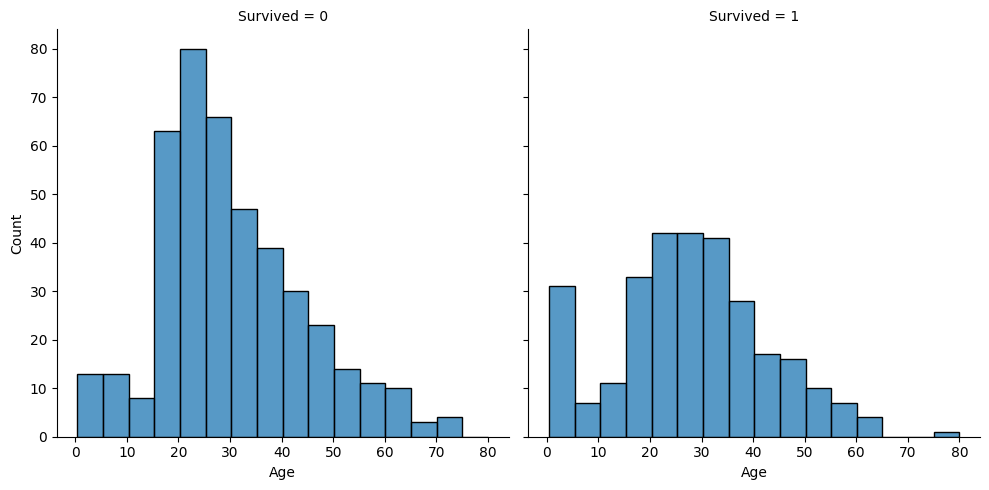

In [56]:
sns.displot(training, x='Age', col='Survived', binwidth=5)

To enhance this, I may cut the ages down into groups using qcut and loc to help. This is not being done right now as i would rather use individual ages to further enhance the accuracy of any models.

Fare

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


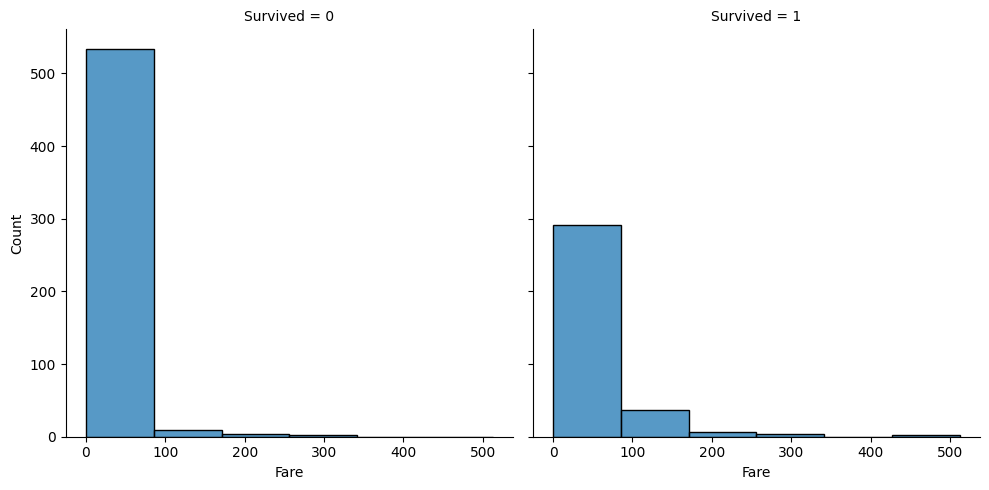

In [61]:
sns.displot(training, x='Fare', col='Survived', binwidth=80)

Due to the uneven distribution, I will use Qcut on this data and see the results.